In this notebook, we'll experiment to see how adding more patrons to a market can change the long term outcome of the market. As usual, here are a few utility functions.

In [1]:
WEI = 1
GWEI = 10**9
WHOLE = 10**18

def wei_to_whole(amount):
    return amount // 10**18

def gwei_to_whole(amount):
    return amount // 10**9

def gwei_to_wei(amount):
    return amount * 10**9

def wei_to_gwei(amount):
    return amount // 10**9

def convert_support_price(price):
    """Support price is ETH wei / MKT gwei. Convert to ETH whole / MKT whole"""
    # ETH gwei / MKT gwei
    price_gwei_to_gwei = wei_to_gwei(price)
    # Note units cancel
    price_whole_to_whole = price_gwei_to_gwei
    return price_whole_to_whole

Here are the market parameters. The rest of the notebook is designed so that if you change these parameters, the rest of the notebook should execute correctly

In [2]:
PRICE_FLOOR = int(.001 * GWEI)
SPREAD = 110 # 10 %
LIST_REWARD = .000025 * WHOLE # MKT
STAKE = .01 * WHOLE # MKT
VOTE_BY = 7 # Days. Are units right?
BACKEND_PAYMENT = 5
MAKER_PAYMENT = 25
RESERVE_PAYMENT = 100 - BACKEND_PAYMENT - MAKER_PAYMENT
COST_PER_BYTE = 100 * GWEI # ETH

Ok, now let's define the parameters that govern the current simulation. 

In [3]:
SUPPORT = 1000 * WHOLE # ETH
CREATOR_SUPPORT = 100 * WHOLE # ETH
#N_MAKERS = 1000
# This is number of listings *per* maker
N_LISTINGS_PER_MAKER = 100
# Size of an individual data purchase in ETH
PURCHASE_SIZE = 1000 * WHOLE # ETH
## Number of purchases
#N_PURCHASES = 90

One of the core assumptions of this simulation is that makers are rational and are drawn into the market with larger reserve. For now, we model this as a very simple curve that assumes that the addition of 10 ETH is enough to motivate a new maker to enter the market.

In [4]:
def get_number_makers(reserve_size):
    return reserve_size // 10

A second core assumption is that buyers are drawn to markets with more listings. For now, we model this as a very simple curve that assumes that the addition of 100 listings is enough to motivate a new buyer to enter the market.

In [5]:
def get_number_buyers(n_listings):
    return n_listings // 100

We have one large cell that models the entire simple market simulation.

In [6]:

def run_simulation(N_PATRONS):
  print("-------------------------------------------------------------")
  print("Running simulation with %d patrons" % N_PATRONS)
  RESERVE = 0 # Initial reserve is empty
  MARKET_TOTAL = 0 # No Market tokens at start

  # Creator does their thing
  CREATOR_BLOCK_SIZE = 1 * WHOLE # MKT
  MARKET_TOTAL += CREATOR_BLOCK_SIZE
  # Creator deposits funds in reserve
  RESERVE += CREATOR_SUPPORT
  print("MARKET_TOTAL: %d, RESERVE: %d" % (wei_to_whole(MARKET_TOTAL), wei_to_whole(RESERVE)))

  # Data Structure to keep track of coin table
  coin_table = {}
  # We're just going to use whole units for convenience
  coin_table["CREATOR"] = CREATOR_BLOCK_SIZE / 10**18

  # Now some patrons join the market.
  print("SUPPORT: %d" % wei_to_whole(SUPPORT))
  for i in range(N_PATRONS):
      print("Patron %d supports" % (i+1))
      SUPPORT_PRICE = PRICE_FLOOR + ((SPREAD * RESERVE * GWEI) // (100 * MARKET_TOTAL))
      print("SUPPORT_PRICE (ETH whole for MKT whole): %d" % convert_support_price(SUPPORT_PRICE))
      MINTED = (SUPPORT // SUPPORT_PRICE) * GWEI # Units of WEI
      print("MINTED: %f" % (MINTED / 10**18))
      MARKET_TOTAL += MINTED
      RESERVE += SUPPORT
      coin_table["PATRON_%d" % (i+1)] = MINTED / 10**18

  # Now let's add some makers
  N_MAKERS = get_number_makers(RESERVE // 10**18)
  print("%d makers have entered a market with reserve %d"% (N_MAKERS, RESERVE // 10**18))
  for i in range(N_MAKERS):
      for j in range(N_LISTINGS_PER_MAKER):
          MAKER = "MAKER_%d" % (i+1)
          MINTED = LIST_REWARD
          MARKET_TOTAL += MINTED
          if MAKER not in coin_table:
              coin_table[MAKER] = 0
          coin_table[MAKER] += MINTED/10**18
  N_LISTINGS = N_MAKERS * N_LISTINGS_PER_MAKER
  print("%d listings total added" % N_LISTINGS)

  # Now let's add some purchases
  BACKEND_REVENUE = 0
  N_BUYERS = get_number_buyers(N_LISTINGS)
  print("%d buyers total entering the market" % N_BUYERS)
  for n in range(N_BUYERS):
      #print("Purchase %d" % n)
      PURCHASE = PURCHASE_SIZE
      BACKEND_SHARE = (PURCHASE * BACKEND_PAYMENT)//100
      MAKER_SHARE = (PURCHASE * MAKER_PAYMENT)//100
      RESERVE_SHARE = (PURCHASE * RESERVE_PAYMENT)//100
      # Pay out the reserve share
      RESERVE += RESERVE_SHARE
      # Backend share is paid directly to backend
      BACKEND_REVENUE += BACKEND_SHARE
      # The maker share is created via the support() function. Let's find the current support price:
      SUPPORT_PRICE = PRICE_FLOOR + ((SPREAD * RESERVE * GWEI) // (100 * MARKET_TOTAL))
      #print("SUPPORT_PRICE (ETH whole for MKT whole): %d" % convert_support_price(SUPPORT_PRICE))
      # Now mint the makers their access rewards
      ONE_MAKER_SHARE = MAKER_SHARE // N_MAKERS
      MINTED = (ONE_MAKER_SHARE // SUPPORT_PRICE) * GWEI # Units of WEI
    
  print("#####################")
  print("MARKET_TOTAL: %f" % (MARKET_TOTAL / 10**18))
  print("RESERVE: %f" % (RESERVE / 10**18))
  CREATOR_ETH = (coin_table["CREATOR"]/(MARKET_TOTAL / 10**18)) * (RESERVE / 10**18)
  print("CREATOR ETH: %f" % CREATOR_ETH)
  CREATOR_PROFIT = CREATOR_ETH - (CREATOR_SUPPORT / 10**18)
  print("CREATOR PROFIT: %f" % CREATOR_PROFIT)
  # All patrons have the same share
  PATRON_ETH = (coin_table["PATRON_1"]/(MARKET_TOTAL / 10**18)) * (RESERVE / 10**18)
  print("BACKEND_REVENUE: %f" % (BACKEND_REVENUE / 10**18))
  print("PATRON ETH: %f" % PATRON_ETH)
  PATRON_PROFIT = PATRON_ETH - (SUPPORT/10**18)
  print("PATRON_PROFIT: %f" % PATRON_PROFIT)
  MAKER_ETH = (coin_table["MAKER_1"]/(MARKET_TOTAL / 10**18)) * (RESERVE / 10**18)
  print("MAKER ETH: %f" % MAKER_ETH)
  print("Ending simulation")
  print("-------------------------------------------------------------")
  return (RESERVE / 10**18)

patrons_list = [n_patrons + 1 for n_patrons in range(10)]
reserve_sizes = []
for n_patrons in patrons_list:
    reserve_size = run_simulation(N_PATRONS=n_patrons)
    reserve_sizes.append(reserve_size)  

-------------------------------------------------------------
Running simulation with 1 patrons
MARKET_TOTAL: 1, RESERVE: 100
SUPPORT: 1000
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 110
MINTED: 9.090826
110 makers have entered a market with reserve 1100
11000 listings total added
110 buyers total entering the market
#####################
MARKET_TOTAL: 10.365826
RESERVE: 78100.000000
CREATOR ETH: 7534.372720
CREATOR PROFIT: 7434.372720
BACKEND_REVENUE: 5500.000000
PATRON ETH: 68493.674782
PATRON_PROFIT: 67493.674782
MAKER ETH: 18.835932
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 2 patrons
MARKET_TOTAL: 1, RESERVE: 100
SUPPORT: 1000
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 110
MINTED: 9.090826
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 119
MINTED: 8.339456
210 makers have entered a market with reserve 2100
21000 list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[78100.0, 149100.0, 220100.0, 291100.0, 362100.0, 433100.0, 504100.0, 575100.0, 646100.0, 717100.0]


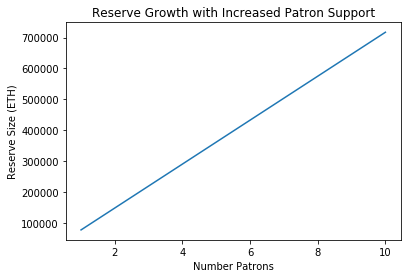

In [8]:
import matplotlib.pyplot as plt
print(patrons_list)
print(reserve_sizes)
plt.title("Reserve Growth with Increased Patron Support")
plt.xlabel("Number Patrons")
plt.ylabel("Reserve Size (ETH)")
plt.plot(patrons_list, reserve_sizes)